# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt


# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

/home/leodecio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pandas as pd
from math import  ceil,floor

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#COCO_MODEL_PATH =  '../../mask_rcnn_coco.h5'
COCO_MODEL_PATH =  './models/mask_rcnn_coco.h5'
IMAGENET_MODEL_PATH =  './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

PATH_IMAGES = '/home/leodecio/Imagens/datasets/voc2005_1/VOC2005_1/'


## Configurations

In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, X, init, end, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "Bicycle")
        self.add_class("shapes", 2, "Person")
        self.add_class("shapes", 3, "Car")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        bg_color = np.array([255, 255, 255])
        count = 0
        
        for img in range(init,end):
            n = X[img]
            if('bike' in n[0]):
                shapes = ("Bicycle",)
            if('cars' in n[0]):
                shapes = ("Car",)
            if('person' in n[0]):
                shapes = ("Person",)
            self.add_image("shapes", image_id=count, path=n,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        #image = np.ndarray(image_rows, image_cols,3), dtype=np.uint8)
        
        #image = image * bg_color.astype(np.uint8)
        
        img = cv2.imread(info['path'][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        image = img
        
        return image
        
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], 3], dtype=np.uint8)
        
        mask_ = cv2.imread(info['path'][1])
        #mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2RGB)
        mask_ = cv2.resize(mask_, (128, 128))
        mask = mask_
        
        class_ids = np.array([self.class_names.index(s) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [8]:
data = pd.read_csv(PATH_IMAGES+'annotations.csv',header=None)
X = data.values

In [9]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(X,0,int(len(X)*0.7),128, 128)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(X, int(len(X)*0.7),len(X), 128, 128)
dataset_val.prepare()

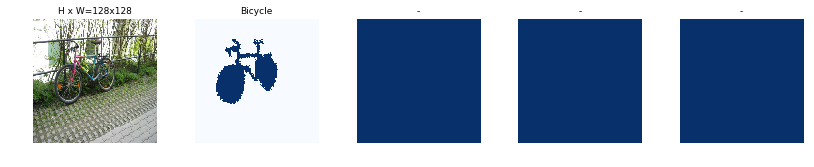

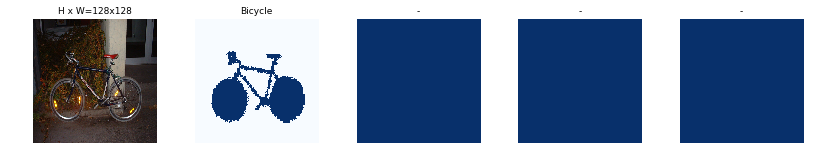

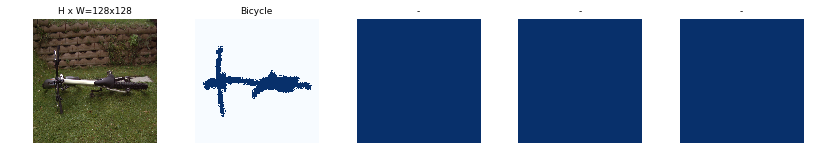

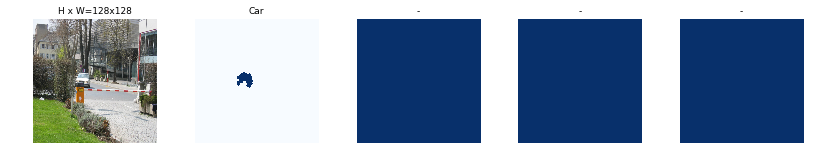

In [10]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/leodecio/workspaceDL/visão/mask/Mask_RCNN/samples/logs/shapes20181123T1838/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

/home/leodecio/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/leodecio/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 99/100 [============================>.] - ETA: 25s - loss: 2.2416 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.1929 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4920 - mrcnn_mask_loss: 0.2902

/home/leodecio/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:272: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 2569s 26s/step - loss: 2.2290 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.1856 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.4888 - mrcnn_mask_loss: 0.2892 - val_loss: 7.4597 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 1.3185 - val_mrcnn_class_loss: 0.8674 - val_mrcnn_bbox_loss: 1.4204 - val_mrcnn_mask_loss: 3.8246


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [23]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "___mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [12]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)
model.load_weights('/home/leodecio/workspaceDL/visão/mask/Mask_RCNN/samples/logs/___mask_rcnn_shapes.h5', by_name=True)
#model.load_weights('../../mask_rcnn_coco.h5', by_name=True)

original_image           shape: (128, 128, 3)         min:   23.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool
.


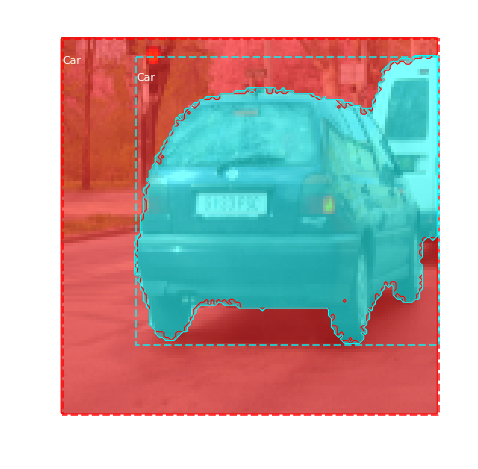

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           5, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
.


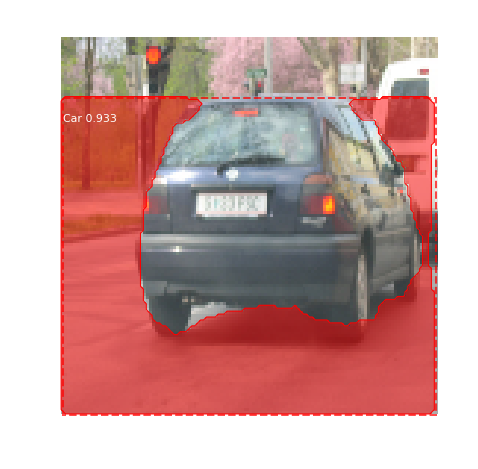

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [26]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 15)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.03333333333333333
